## Imports

In [ ]:
# models
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# model selection
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA

# preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

# utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

## Data loading

In [22]:
data_dir = "data"

X_g_train = np.load(f"{data_dir}/guided/guided_dataset_X.npy")
y_g_train = np.load(f"{data_dir}/guided/guided_dataset_y.npy")
X_g_test = np.load(f"{data_dir}/guided/guided_testset_X.npy")

X_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_X.npy")
y_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_y.npy")
X_f_test = np.load(f"{data_dir}/freemoves/freemoves_testset_X.npy")


In [23]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


## Data preparation

In [24]:
class FeatureWindowAugment(BaseEstimator, TransformerMixin):
    """
    + Augment X through overlapping windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        X_windows = np.lib.stride_tricks.sliding_window_view(X,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        X_windows = X_windows[:,:,::step,:]
         
        # (session, electrode, window, time) to (session, window, electrode, time)
        X_windows = X_windows.transpose(0, 2, 1, 3) 
        
        return X_windows   

In [25]:
   
class WindowTargetExtractor(BaseEstimator, TransformerMixin):
    """
    + augment y through overlapping windows 
    + extract the target, i.e. unique hand pose (51 val) of the correspondoing window (500 'samples')
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, y, X=None):
        return self
    
    def transform(self, y, X=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # ----- window augment -----
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        y_windows = np.lib.stride_tricks.sliding_window_view(y,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        y_windows = y_windows[:,:,::step,:]
         
        # (session, angles, window, time) to (session, window, angles, time)
        y_windows = y_windows.transpose(0, 2, 1, 3)     
        
        # ----- target extract -----
        y_windows = y_windows[:, :, :, -1] # last hand pose

        return y_windows

Prepared data

In [26]:
X_g_train_wdw = FeatureWindowAugment().transform(X_g_train)
y_g_train_wdw = WindowTargetExtractor().transform(y_g_train)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / X_g_test {X_g_test.shape}")
print(f"y_g_train_wdw{y_g_train_wdw.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / X_g_test (5, 332, 8, 500)
y_g_train_wdw(5, 919, 51)


## Common time features extraction

extract features from X set windows
+ Mean Absolute Value (MAV)
+ Root Mean Square (RMS)
+ Variance (VAR)
+ Standard Deviation (STD)
+ Zero Crossing (ZC)
+ Myopulse Percentage Rate (MPR)

In [27]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extracts common time-domain features, from numpy arrays into a dataframe (readability)
    """

    def __init__(self, mpr_threshold=0.5):
        self.mpr_threshold = mpr_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        # --- Feature extraction ---
        feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
        n_features = len(feature_names)
        
        n_sessions, n_windows, n_electrodes, n_times = X.shape
        features = np.zeros((n_sessions * n_windows, n_electrodes * n_features))
        
        for s in range(n_sessions):
            for w in range(n_windows):
                i = s*n_windows + w # index in flattened contiguous windows samples 'form'
                wdw_features = []
                for e in range(n_electrodes):
                    signal = X[s, w, e, :] # window signal
                    
                    mav = np.mean(np.abs(signal))
                    rms = np.sqrt(np.mean(signal**2))
                    var = np.var(signal)
                    std = np.std(signal)
                    zc = np.sum(np.diff(np.signbit(signal)).astype(int))
                    mpr = np.mean(np.abs(signal) > self.mpr_threshold)    
                    wdw_features.extend([mav, rms, var, std, zc, mpr])
                
                features[i, :] = wdw_features
        
        # --- to Dataframe ---            
        column_names = [f"elec{e}_{name}" for e in range(n_electrodes) for name in feature_names]
        df = pd.DataFrame(features, columns=column_names)
        
        return df

In [28]:
class TargetFlattener(BaseEstimator, TransformerMixin):
    """
    Flatten feature set for sklearn usability
    """

    def fit(self, y, X=None):
        return self

    def transform(self, y, X=None):      
        
        # -- Reshape --
        n_sessions, n_windows, n_angles = y.shape
        
        # Reshape to (sessions*windows, angles)
        y_flat = y.reshape(n_sessions * n_windows, n_angles)
        
        # n_vals = 3 # 3 'values' per joint angle
        # column_names = [f"angle{i}_{k}" for i in range(0, n_angles, n_vals) for k in range(n_vals)]
        
        # df = pd.DataFrame(y_flat, columns=column_names)
        
        return y_flat

Preprocessed data 

In [30]:
X_g_train_preproc = FeatureExtractor().transform(X_g_train_wdw)
y_g_train_preproc = TargetFlattener().transform(y_g_train_wdw)

print("Guided preprocessed:")
print(f"X_g_train_preproc {X_g_train_preproc.shape}")
print(f"y_g_train_preproc{y_g_train_preproc.shape}")

Guided preprocessed:
X_g_train_preproc (4595, 48)
y_g_train_preproc(4595, 51)


In [34]:
X_g_train_preproc

,elec0_MAV,elec0_RMS,elec0_VAR,elec0_STD,elec0_ZC,elec0_MPR,elec1_MAV,elec1_RMS,elec1_VAR,elec1_STD,...,elec6_VAR,elec6_STD,elec6_ZC,elec6_MPR,elec7_MAV,elec7_RMS,elec7_VAR,elec7_STD,elec7_ZC,elec7_MPR
0,6.701652,8.662048,74.883873,8.653547,163.0,0.970,10.965515,14.342263,204.203903,14.289993,...,110.836147,10.527875,185.0,0.944,5.643074,7.145505,44.822074,6.694929,155.0,0.934
1,7.178799,9.199120,84.616388,9.198717,154.0,0.964,16.069970,22.610408,510.337299,22.590646,...,151.903128,12.324899,142.0,0.954,5.404592,6.914727,38.852225,6.233155,151.0,0.930
2,9.718116,14.565290,212.041260,14.561637,122.0,0.956,42.809065,72.638271,5275.741805,72.634302,...,148.106585,12.169905,132.0,0.960,5.202890,6.615519,39.231304,6.263490,157.0,0.934
3,32.977899,52.550206,2761.523900,52.550204,116.0,0.972,142.512546,226.213410,51160.179792,226.186162,...,673.760371,25.956894,125.0,0.968,32.033988,69.323298,4786.810640,69.186781,150.0,0.964
4,44.143445,59.523193,3542.781532,59.521270,119.0,0.988,173.606587,242.164379,58624.377947,242.124716,...,896.614832,29.943527,137.0,0.982,53.617873,85.759348,7335.050738,85.644911,120.0,0.988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,39.380708,51.365539,2638.322399,51.364603,118.0,0.986,79.932563,104.180417,10853.498404,104.180125,...,151.717625,12.317371,133.0,0.960,75.566471,103.360258,10675.728400,103.323417,91.0,0.996
4591,34.636152,44.094328,1942.868497,44.077982,129.0,0.988,60.779324,77.576558,6018.117470,77.576527,...,122.446274,11.065544,125.0,0.940,77.742801,107.628104,11564.048025,107.536264,95.0,0.994
4592,30.032139,39.257755,1540.904708,39.254359,141.0,0.988,61.986167,81.651908,6666.699861,81.649861,...,110.411136,10.507670,118.0,0.948,73.109557,102.143978,10420.727048,102.081962,98.0,0.990
4593,26.228277,34.169712,1167.415380,34.167461,140.0,0.990,68.887126,88.845440,7886.425848,88.805551,...,90.440675,9.510030,134.0,0.946,71.037387,98.248798,9648.619024,98.227384,97.0,0.994


In [35]:
y_g_train_preproc

array([[ 41.69509276, -64.84230148, -33.44328515, ...,  -2.40615756,
         -3.83633095, -71.75859096],
       [ 42.21137775, -65.31616912, -35.40917832, ...,  -2.39942293,
         -3.85264717, -71.36065884],
       [ 40.58962944, -64.01487726, -29.55026783, ...,  -2.11967921,
         -4.42828784, -57.32531111],
       ...,
       [ 33.22025054, -60.91298608,  -7.01284031, ...,  -2.2405282 ,
         -4.22719802, -62.45920523],
       [ 33.38519751, -60.93800321,  -7.46505753, ...,  -2.27859921,
         -4.15133207, -64.31607844],
       [ 33.50012485, -60.95666721,  -7.78121825, ...,  -2.28070865,
         -4.14687973, -64.42327327]])

## Cross validation

strategy: session based Leave One Group Out

+ no **window overlap leakage**
+ avoids **session bias**: signal drift, sensors placements, ... 

In [36]:
n_sessions, n_windows, n_electrodes, n_times = X_g_train_wdw.shape
groups = np.repeat(np.arange(1,n_sessions+1), n_windows) # [1 ... 1], [2 ... 2], ..., [5 ...5] each group of lenght n_windows

# loss functions
def mse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)
def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true-y_hat)**2))
def nmse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)/np.std(y_true)**2

# scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
nmse_scorer = make_scorer(nmse, greater_is_better=False)

# cv function 
logo = LeaveOneGroupOut()
def logo_cv(X, y, model, scorer=rmse_scorer):
    cv_scores = cross_val_score(model, X, y, groups=groups, cv=logo, scoring=scorer, n_jobs=-1)
    return np.mean(-cv_scores)

def _logo_cv(X, y, model):
    cv_nmse = []
    cv_rmse = []
    for train_index, test_index in logo.split(X, y, groups):
        X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_ts = y[train_index], y[test_index]
        
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_ts)
        cv_nmse.append(nmse(y_ts, y_hat))
        cv_rmse.append(rmse(y_ts, y_hat))
        
    return (np.mean(cv_rmse), np.mean(cv_nmse))

## Baselines

1) 
    + try multiple baselines with very minimal tuning to get a rough direction and idea (early signal) of what models (assumptions) seems to work well on data, also gives a cv score baseline that more complex models should beat.
    + keep the best/most promising 2 or 3 (dont waste effort on non promising models)

2) feature importance

3) final baseline model selection, hyper parametre tuning and preprocessing steps interact ! thus we must make decisions considering them together (also avoids leakage!). So nested cv is used.


#### 1) Baseline 'exploration'

In [97]:
cv_results_baselines = {}
from sklearn.dummy import DummyRegressor
baselines = {
    'dummy_mean': DummyRegressor(strategy='mean'),
    "OLS": LinearRegression(),
    "knn": KNeighborsRegressor(),
    'random_forest': RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=10),
}

for name, model in baselines.items():
    cv_rmse, cv_nmse = _logo_cv(X_g_train_preproc, y_g_train_preproc, model)
    cv_results_baselines[name] = {"RMSE": cv_rmse, "NMSE": cv_nmse}

baselines_cv_df = pd.DataFrame(cv_results_baselines).T
baselines_cv_df

,RMSE,NMSE
dummy_mean,14.259043,0.437812
OLS,7.248052,0.113622
knn,5.506158,0.067691
random_forest,5.094033,0.056900


(slight tuning ?)

In [120]:
from sklearn.multioutput import MultiOutputRegressor

# model = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0), n_jobs=-1)
model = MultiOutputRegressor(LinearRegression())
cv_rmse = _logo_cv(X_g_train_preproc, y_g_train_preproc, model)[0]
cv_rmse


np.float64(7.248052301227896)

#### 2) Feature importance

**OLS**

TODO: epxlanations

```python
coef_ = [w_1_1, w_1_2, ..., w_1_48],  # weights of model 1
        ...
        [w_51_1, ..., w_51_48]        # weights of model 51
```
For interpretability and general insight we aggregate the feature importances across all outputs by taking the mean.

(inspired by [source](https://sourcebae.com/blog/how-to-get-coefficients-and-feature-importances-from-multioutputregressor/) and Tp5)

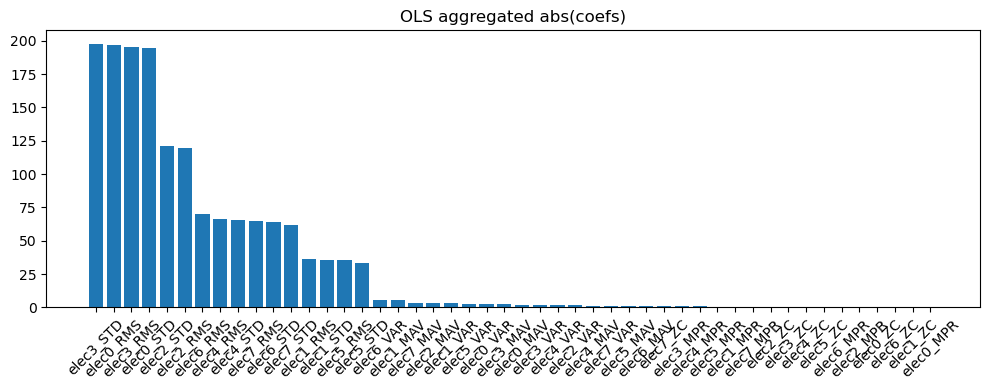

In [163]:
# OLS
ols_reg = LinearRegression(n_jobs=-1)
ols_reg_pipe = make_pipeline(StandardScaler(), ols_reg)
ols_reg_pipe.fit(X_g_train_preproc, y_g_train_preproc)

aggr_coef = np.mean(np.abs(ols_reg.coef_), axis=0) # average on columns
ols_sorted_idx = np.argsort(aggr_coef)[::-1] # descending order
column_names = X_g_train_preproc.columns

plt.figure(figsize=(10, 4))
plt.bar(range(len(aggr_coef)), aggr_coef[ols_sorted_idx], align='center')
plt.xticks(range(len(aggr_coef)), column_names[ols_sorted_idx], rotation=45)
plt.title("OLS aggregated abs(coefs)")
plt.tight_layout()
plt.show()

**KNN**

KNeighborsRegressor doesnt provide coefficients or feature importances, so we must use alternative, less robust approaches, here we use permutation importance that basically measures the drop in performance when each feature is shuffled. 

TODO: explain more [src](https://scikit-learn.org/stable/modules/permutation_importance.html)

In [108]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_g_train_preproc, y_g_train_preproc)
model = KNeighborsRegressor()
model.fit(X_train, y_train)

knn_feat_imp = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0, n_jobs=-1)

for i in knn_feat_imp.importances_mean.argsort()[::-1]:
    if knn_feat_imp.importances_mean[i] - 2 * knn_feat_imp.importances_std[i] > 0:        
        print(f"{X_train.columns[i]}\t {knn_feat_imp.importances_mean[i]:.3f} +/- {knn_feat_imp.importances_std[i]:.3f}")

elec3_VAR	 0.634 +/- 0.023
elec1_VAR	 0.539 +/- 0.022
elec2_VAR	 0.522 +/- 0.024
elec7_VAR	 0.268 +/- 0.015
elec4_VAR	 0.245 +/- 0.012
elec0_VAR	 0.162 +/- 0.010
elec5_VAR	 0.114 +/- 0.007


**Random forest**

TODO: explanations [src](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html?utm_source=chatgpt.com)


<!-- 
Native multi‑output trees in scikit‑learn (e.g. DecisionTreeRegressor, RandomForestRegressor) treat the target Y as an (n samples,n outputs) array and, at each split, compute the impurity decrease as the sum of variances (for regression) across all outputs.

During fitting, each tree accumulates, for every feature, how much splitting on that feature reduces the total (sum‑of‑variance) impurity across all outputs

feature_importances_ is then the average, over all trees, of those total impurity‑reduction scores—one single importance per input feature that reflects its contribution jointly to all outputs.

Interpretation: A higher importance means “this feature, when used in splits, reduced the overall error summed over all 51 targets more than other features.
 -->

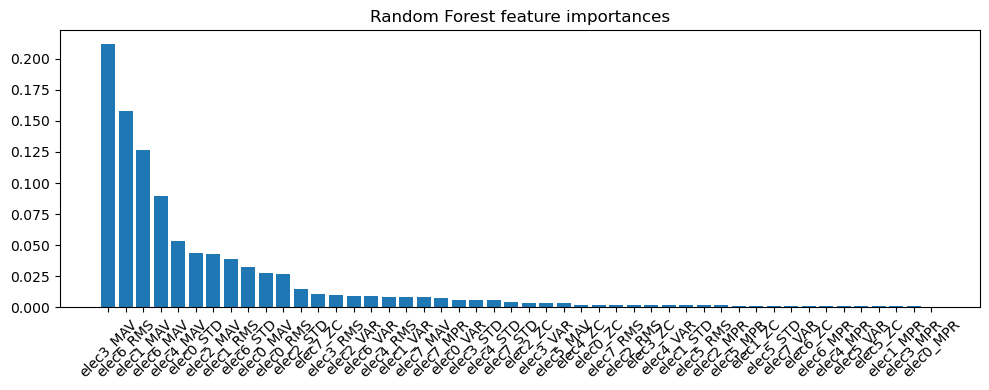

In [131]:
rf = RandomForestRegressor(random_state=0, n_estimators=10)
rf.fit(X_g_train_preproc, y_g_train_preproc)
rf_feat_imp = rf.feature_importances_
rf_sorted_idx = np.argsort(rf_feat_imp)[::-1] # descending order

column_names = X_g_train_preproc.columns

plt.figure(figsize=(10, 4))
plt.bar(range(len(rf_feat_imp)), rf_feat_imp[rf_sorted_idx], align='center')
plt.xticks(range(len(rf_feat_imp)), column_names[rf_sorted_idx], rotation=45)
plt.title("Random Forest feature importances")
plt.tight_layout()
plt.show()

#### 3) Feature selection

In [53]:
# feature selection / preprocessing steps ...
feature_selections = {
    "PCA": PCA(),
    "k_best": SelectKBest(score_func="mean_squared_error")
}

In [48]:
# nested cv

#### 4) Final baseline

## More complex approaches